In [41]:
shaking <- function(solution, k) {
  n <- length(solution)
  for (i in 1:k) {
    idx <- sample(1:n, 2)
    solution[idx] <- solution[rev(idx)]
  }
  return(solution)
}


In [42]:
local_search <- function(bins, bin_capacity, binpacking_instance) {
  current_solution <- bins
  best_solution <- current_solution
  best_cost <- binpacking_instance$evaluate(current_solution)
  
  improved <- TRUE
  while (improved) {
    improved <- FALSE
    for (i in 1:(length(current_solution) - 1)) {
      for (j in (i + 1):length(current_solution)) {
        new_solution <- current_solution
        new_solution[c(i, j)] <- new_solution[c(j, i)]
        new_cost <- binpacking_instance$evaluate(new_solution)
        if (new_cost < best_cost) {
          best_solution <- new_solution
          best_cost <- new_cost
          improved <- TRUE
          break # Sal de los bucles internos
        }
      }
      if (improved) break # Sal del bucle externo si se encuentra una mejora
    }
    if (improved) {
      current_solution <- best_solution
    }
  }
  
  return(best_solution)
}


In [43]:
BinPacking <- setRefClass(
  "BinPacking",
  fields = list(
    item_sizes = "numeric",
    bin_capacity = "numeric"
  ),
  methods = list(
    evaluate = function(permutation) {
      bin_capacities <- numeric() 
      current_bin_capacity <- 0  

      for (i in permutation) {
        item_size <- item_sizes[i]
        if (current_bin_capacity + item_size <= bin_capacity) {
          current_bin_capacity <- current_bin_capacity + item_size
        } else {
          bin_capacities <- c(bin_capacities, current_bin_capacity) 
          current_bin_capacity <- item_size  
        }
      }
      bin_capacities <- c(bin_capacities, current_bin_capacity)  
      return(length(bin_capacities)) 
    }
  )
)


In [44]:
read_bin_packing_instance <- function(filename) {
  lines <- readLines(filename)
  P <- as.integer(lines[1])  # Número de instancias de problemas
  problems <- list()
  index <- 2
  for (i in 1:P) {
    problem_id <- trimws(lines[index])
    index <- index + 1
    bin_info <- strsplit(trimws(lines[index]), "\\s+")[[1]]
    bin_capacity <- as.numeric(bin_info[1])
    num_items <- as.integer(bin_info[2])
    best_known_solution <- as.integer(bin_info[3])
    index <- index + 1
    items <- numeric(num_items)
    for (j in 1:num_items) {
      items[j] <- as.numeric(trimws(lines[index]))
      index <- index + 1
    }
    problems[[i]] <- list(
      problem_id = problem_id,
      bin_capacity = bin_capacity,
      num_items = num_items,
      best_known_solution = best_known_solution,
      items = items
    )
  }
  return(problems)
}

In [45]:
# Función Best Fit
best_fit_decreasing <- function(elements, container_capacity) {
  original_indices <- seq_along(elements)
  sorted_indices <- order(elements, decreasing = TRUE)
  elements_sorted <- elements[sorted_indices]
  
  containers <- list()
  assignments <- integer(length(elements)) 
  
  for (i in seq_along(elements_sorted)) {
    element <- elements_sorted[i]
    best_fit_index <- -1
    min_space_left <- container_capacity + 1
    
    for (j in seq_along(containers)) {
      space_left <- container_capacity - sum(unlist(containers[[j]]))
      if (space_left >= element && space_left < min_space_left) {
        min_space_left <- space_left
        best_fit_index <- j
      }
    }
    
    if (best_fit_index == -1) {
      containers <- append(containers, list(c(element)))
      best_fit_index <- length(containers)
    } else {
      containers[[best_fit_index]] <- c(containers[[best_fit_index]], element)
    }
    
    assignments[sorted_indices[i]] <- best_fit_index
  }
  
  return(assignments)
}

In [46]:
# Función para transformar la solución en una lista de contenedores
transform_solution <- function(solution, item_sizes, bin_capacity) {
  bins <- list()
  current_bin <- numeric()
  current_bin_capacity <- 0
  
  for (i in solution) {
    item_size <- item_sizes[i]
    if (current_bin_capacity + item_size <= bin_capacity) {
      current_bin <- c(current_bin, item_size)
      current_bin_capacity <- current_bin_capacity + item_size
    } else {
      bins <- c(bins, list(current_bin))
      current_bin <- item_size
      current_bin_capacity <- item_size
    }
  }
  bins <- c(bins, list(current_bin))
  return(bins)
}

In [47]:
vns <- function(binpacking_instance, max_iter = 100, max_no_improve = 10) {
  initial_solution <- best_fit_decreasing(binpacking_instance$item_sizes, binpacking_instance$bin_capacity)
  cat("initial solution", initial_solution, "\n")
  best_solution <- initial_solution
  best_cost <- binpacking_instance$evaluate(best_solution)
  no_improve <- 0
  
  cost_per_iteration <- numeric(max_iter) 
  
  for (iter in 1:max_iter) {
    k <- 1
    while (k <= max_no_improve) {
      new_solution <- shaking(best_solution, k)
      new_solution <- local_search(new_solution, binpacking_instance$bin_capacity, binpacking_instance)
      new_cost <- binpacking_instance$evaluate(new_solution)
      
      if (new_cost < best_cost) {
        best_solution <- new_solution
        best_cost <- new_cost
        no_improve <- 0
        k <- 1
      } else {
        k <- k + 1
        no_improve <- no_improve + 1
      } 
      if (no_improve >= max_no_improve) break
    }
    cost_per_iteration[iter] <- best_cost 
  }
  
  return(list(solution = best_solution, cost_per_iteration = cost_per_iteration))
}


In [19]:
file_path <- "./instances/binpack1.txt"
instances <- read_bin_packing_instance(file_path)
instance <- instances[[1]]
instance

Warning message in readLines(filename):
"incomplete final line found on './instances/binpack1.txt'"


$problem_id
[1] "u120_00"

$bin_capacity
[1] 150

$num_items
[1] 120

$best_known_solution
[1] 48

$items
  [1] 42 69 67 57 93 90 38 36 45 42 33 79 27 57 44 84 86 92 46 38 85 33 82 73 49
 [26] 70 59 23 57 72 74 69 33 42 28 46 30 64 29 74 41 49 55 98 80 32 25 38 82 30
 [51] 35 39 57 84 62 50 55 27 30 36 20 78 47 26 45 41 58 98 91 96 73 84 37 93 91
 [76] 43 73 85 81 79 71 80 76 83 41 78 70 23 42 87 43 84 60 55 49 78 73 62 36 44
[101] 94 69 32 96 70 84 58 78 25 80 58 66 83 24 98 60 42 43 43 39

initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 
Execution Time: 222.166 1.075 224.16 0 0 
  [1] 12 26  3  7  7  5 43 17 34 42 39 30 23  8 39 31 14  9 47 45 15 47 24 42 41
 [26] 27 10 41 19 32 36 31 32  6 48 25 44 14 48 37 43  3 42  1 27 47 48 45 25 48
 [51] 46 44 20 18 43  1 21 12 48 46 40 24  2 45 35 43  9  2 10 47 38 19 46  8 11
 [76] 40 38 16 26 45 30 28 36 22 44 33 37 49 42 13 40 20 35 23  4 34 39 15 46 40
[101]  6 33  4  5 29 21 11 35 49 29 18 17 34 28 22 16 13 41 49 44
[1] "Number of bins: 48"


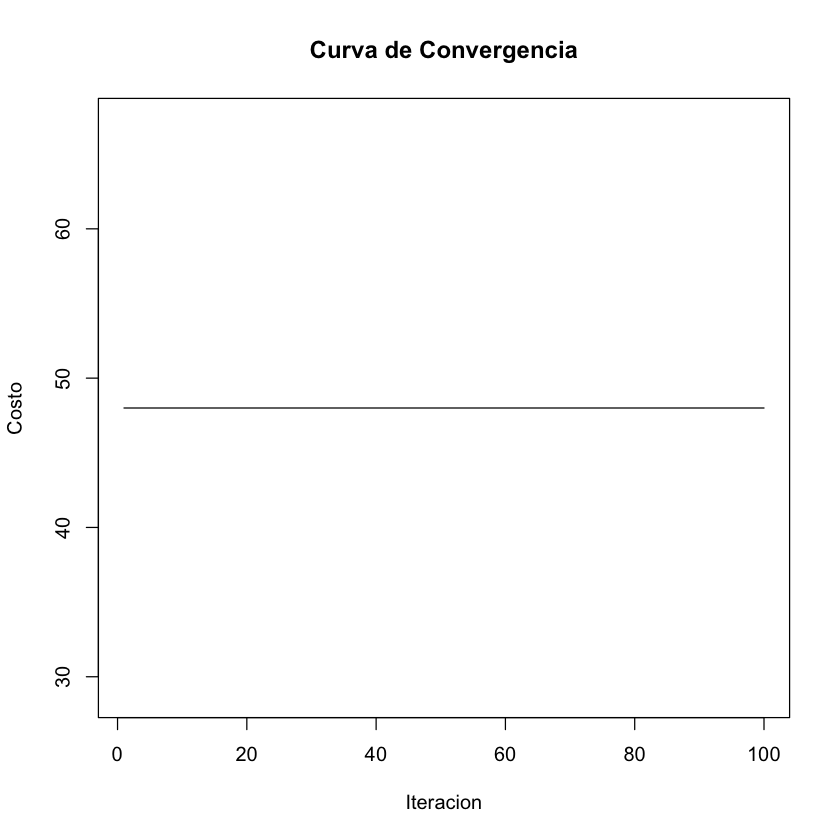

In [50]:
binpacking_instance <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)

execution_time <- system.time({
  result <- vns(binpacking_instance, 100, 5)
}) 

best_solution <- result$solution
cost_per_iteration <- result$cost_per_iteration

# Mostrar resultados
cat("Execution Time:", execution_time, "\n")
print(best_solution)  
print(paste("Number of bins:", binpacking_instance$evaluate(best_solution)))

par(bg = "white")
# Graficar la curva de convergencia
plot(cost_per_iteration, type = 'l', main = "Curva de Convergencia", xlab = "Iteracion", ylab = "Costo", col = "black")
beepr::beep()

In [51]:
file_path <- "./instances/binpack2.txt"
instances <- read_bin_packing_instance(file_path)
instance <- instances[[1]]
instance

Warning message in readLines(filename):
"incomplete final line found on './instances/binpack2.txt'"


$problem_id
[1] "u250_00"

$bin_capacity
[1] 150

$num_items
[1] 250

$best_known_solution
[1] 99

$items
  [1]  42  69  67  57  93  90  38  36  45  42  33  79  27  57  44  84  86  92
 [19]  46  38  85  33  82  73  49  70  59  23  57  72  74  69  33  42  28  46
 [37]  30  64  29  74  41  49  55  98  80  32  25  38  82  30  35  39  57  84
 [55]  62  50  55  27  30  36  20  78  47  26  45  41  58  98  91  96  73  84
 [73]  37  93  91  43  73  85  81  79  71  80  76  83  41  78  70  23  42  87
 [91]  43  84  60  55  49  78  73  62  36  44  94  69  32  96  70  84  58  78
[109]  25  80  58  66  83  24  98  60  42  43  43  39  97  57  81  62  75  81
[127]  23  43  50  38  60  58  70  88  36  90  37  45  45  39  44  53  70  24
[145]  82  81  47  97  35  65  74  68  49  55  52  94  95  29  99  20  22  25
[163]  49  46  98  59  98  60  23  72  33  98  80  95  78  57  67  53  47  53
[181]  36  38  92  30  80  32  97  39  80  72  55  41  60  67  53  65  95  20
[199]  66  78  98  47 100  85  53  53  67  27  22  61  43  52  76  64  61  29
[217]  30  46  79  66  27  79  98  90  22  75  57  67  36  70  99  48  43  45
[235]  71 100  88  48  27  39  38 100  60  42  20  69  24  23  92  32

In [53]:
binpacking_instance <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)

execution_time <- system.time({
  result <- vns(binpacking_instance, 1000, 5)
}) 

best_solution <- result$solution
cost_per_iteration <- result$cost_per_iteration

# Mostrar resultados
cat("Execution Time:", execution_time, "\n")
print(best_solution)  
print(paste("Number of bins:", binpacking_instance$evaluate(best_solution)))

par(bg = "white")
# Graficar la curva de convergencia
plot(cost_per_iteration, type = 'l', main = "Curva de Convergencia", xlab = "Iteracion", ylab = "Costo", col = "black")
beepr::beep()